In [1]:
%reset -f
from pythonrc import *

# %matplotlib qt

In [2]:
time_step = 1.0

actuators = [tunnel, voithschneider_port, voithschneider_starboard]
for actuator in actuators:
    actuator.extra_attributes["rate_limit"] = 0.1
    actuator.extra_attributes.pop("reference_angle", None)

force_torque_components = [
    skadipy.allocator.ForceTorqueComponent.X,
    skadipy.allocator.ForceTorqueComponent.Y,
    skadipy.allocator.ForceTorqueComponent.N,
]

allocators = []
gamma = [1e-3, 1e-3]
mu = [1e-2, 1e-2]
rho = [1.0, 10.0]
zeta = [1.0, 1.0]
lambda_p = [0.99, 0.99]

table = dict_to_table({
    "Run": range(1, len(gamma) + 1),
    r"Frequency": [f"{1.0/time_step} Hz" for i in range(len(gamma))],
    r"$\gamma$" : gamma,
    r"$\mu$" : mu,
    r"$\rho$" : rho,
    r"$\zeta$" : zeta,
    r"$\lambda_i$" : lambda_p,
    r"$\bar{\Omega}_1$" : [actuators[0].extra_attributes['rate_limit']] * len(gamma),
    r"$\bar{\Omega}_2$" : [actuators[1].extra_attributes['rate_limit']] * len(gamma),
    r"$\bar{\Omega}_3$" : [actuators[2].extra_attributes['rate_limit']] * len(gamma),
})
display(Markdown(table))

| Run | Frequency | $\gamma$ | $\mu$ | $\rho$ | $\zeta$ | $\lambda_i$ | $\bar{\Omega}_1$ | $\bar{\Omega}_2$ | $\bar{\Omega}_3$ |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 1.0 Hz | 0.001 | 0.01 | 1.0 | 1.0 | 0.99 | 0.1 | 0.1 | 0.1 |
| 2 | 1.0 Hz | 0.001 | 0.01 | 10.0 | 1.0 | 0.99 | 0.1 | 0.1 | 0.1 |


In [3]:
for g, m, r, l, z in zip(gamma, mu, rho, lambda_p, zeta):

    allocators.append(
        skadipy.allocator.reference_filters.MinimumMagnitudeAndAzimuth(
            actuators=actuators,
            force_torque_components=force_torque_components,
            control_barrier_function=skadipy.safety.ControlBarrierFunctionType.SUMSQUARE,
            derivative=skadipy.toolbox.derivative.ExponentialSmoothing(r=0.1),
            gamma=g,
            mu=m,
            rho=r,
            zeta=z,
            time_step=time_step,
            lambda_=l,
        )
    )

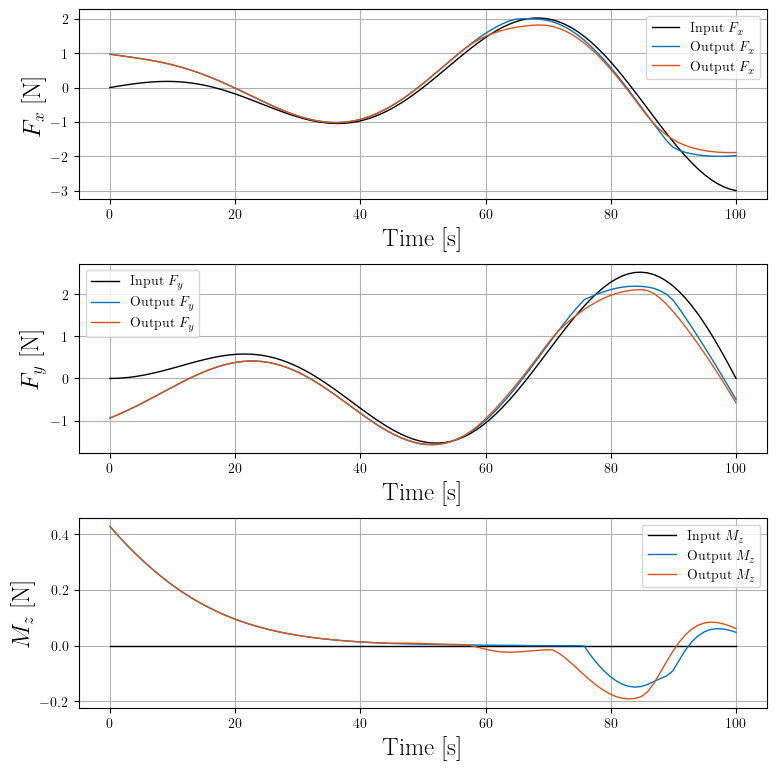

In [4]:
data = generate_spiral_dataset(
    num_points=100,
    num_turns=1.5,
    k=3,
)

tau_cmd = np.concatenate(
    (data, np.zeros((np.shape(data)[0], 4))),
    axis=1
)
d_tau_cmd = np.gradient(tau_cmd, axis=0) / time_step


for allocator in allocators:
    allocator._xi = np.array([[0.0, 0.5, -0.5, 0.5, -0.5]]).T


xi_hist, theta_hist, tau_hist = run_tests(tau_cmd=tau_cmd, d_tau_cmd=d_tau_cmd, allocators=allocators)
fig, ax = plot_histories(tau_cmd=tau_cmd, tau_alloc=tau_hist, dt=time_step)

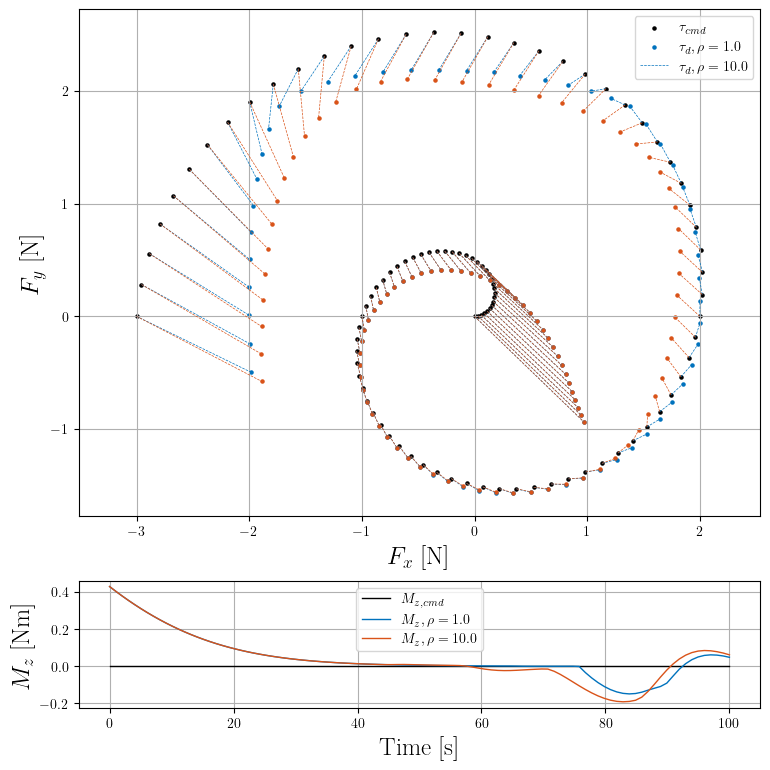

In [5]:
fig, ax = plot_2d_allocation(tau_cmd=tau_cmd, allocators=allocators, tau_hist=tau_hist)

legend_items = []
legend_items.append(r"$\tau_{cmd}$")
for r in rho:
    legend_items.append(f"$\\tau_d, \\rho = {r}$")
ax[0].legend(legend_items)

legend_items = []
legend_items.append(r"$M_{z,cmd}$")
for r in rho:
    legend_items.append(f"$M_z, \\rho = {r}$")
ax[1].legend(legend_items)



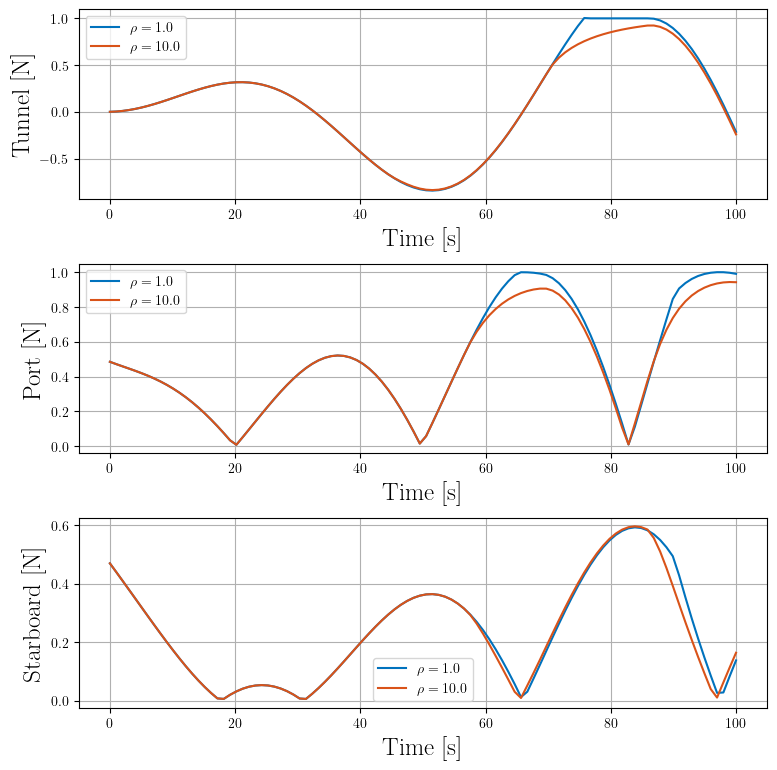

In [6]:
fig, ax = plot_thruster_forces(xi_hist, dt=time_step)

for plot in ax:
    legend_items = []
    for r in rho:
        legend_items.append(f"$\\rho = {r}$")
    plot.legend(legend_items)

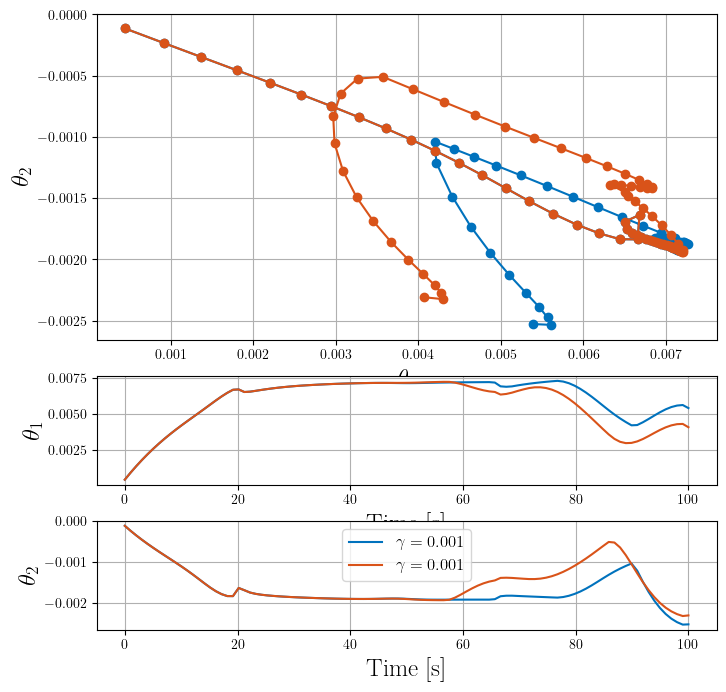

In [7]:
plot_theta_histories(theta_hist)
l = []
for i in gamma:
    l.append(r"$\gamma = {}$".format(i))

plt.legend(l, fontsize=12)

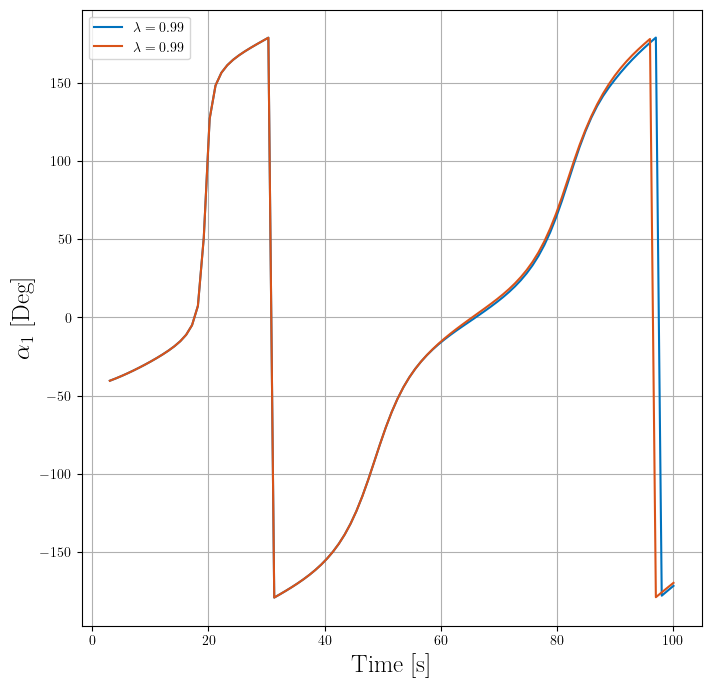

In [8]:
plot_angles(xi_hist, dt=time_step)

l = []
for i in lambda_p:
    l.append(f"$\lambda = {i}$")

plt.legend(l)

plt.grid(True)

In [9]:
save_mat(
    filename="data/014.mat",
    dt=time_step,
    inputs=tau_cmd,
    xi=xi_hist,
    thetas=theta_hist,
    outputs=tau_hist,
    zeta=zeta,
    rho=rho,
    gamma=gamma,
    mu=mu,
    lambda_p=lambda_p,
    thruster=voithschneider_port
)

In [10]:
for i, xi in enumerate(xi_hist):
    max = np.linalg.norm(xi[:,1:2], axis=1).max()

    display(Markdown(rf"Max thrust: {max} at for $\rho = {rho[i]}$"))

Max thrust: 1.001362269146283 at for $\rho = 1.0$

Max thrust: 0.9446860129205749 at for $\rho = 10.0$